# EEGnet SETTINGS

SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100                                                           
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy.io import loadmat
from scipy import signal
from google.colab import drive
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# Install mne library for topoplot
!pip install mne
import mne

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

####################### SETTINGS ########################
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "B"                                  #
#########################################################

subject_names = ["A", "B"]

# Check for errors in the settings
if SUBJECT_SELECTED not in subject_names:
    raise ValueError("SUBJECT_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(SUBJECT_SELECTED, subject_names))

# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = 'drive/MyDrive/project/model/EEGnet/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = 'drive/MyDrive/project/dataset/Subject_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = 'drive/MyDrive/project/dataset/Subject_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = 'drive/MyDrive/project/dataset/channels.csv'
CHANNEL_COORD = 'drive/MyDrive/project/dataset/coordinates.csv'

# Channel selection
CHANNELS = [i for i in range(64)]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.1 MB/s eta 0:00:00
Mounted at /content/drive


# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Obtain windows of 650ms at the start of every flashing (175ms)
3.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
4.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 156, 64)**;
5.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [ ]:
!ls drive/MyDrive/project/dataset

BCI_Competition_IIb	coordinates.csv     Subject_A_Train.mat  Subject_B_Test.rar
BCI_Comp_III_Wads_2004	Subject_A_Test.mat  Subject_A_Train.rar  Subject_B_Train.mat
channels.csv		Subject_A_Test.rar  Subject_B_Test.mat	 Subject_B_Train.rar


In [ ]:
if not os.path.exists(SUBJECT_TRAIN_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TRAIN_FILE_PATH))
else:
    # Load the required data
    data = loadmat(SUBJECT_TRAIN_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    flashing = data['Flashing']
    stimulus = data['StimulusType']
    word = data['TargetChar']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])
    # Set flag to True to balance the training set
    BALANCE_DATASET = False

    print("**********************************")
    print("       TRAIN SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % ''.join(word))

**********************************
       TRAIN SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01 min
Number of letters:  85
Spelled word:       VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO


In [ ]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS):
    signals[trial, :, :] = signal.filtfilt(b, a, signals[trial, :, :], axis=0)

In [ ]:
print("# Samples of EEG signals before downsampling: {}".format(len(signals[0])))

# Samples of EEG signals before downsampling: 7794


In [ ]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals[trial, lower_sample:upper_sample, :]
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 156)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 156, 64)


In [ ]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Obtain windows of 650ms at the start of every flashing (175ms)
3.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
4.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 156, 64)**;
5.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [ ]:
# Test data loading
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}", SUBJECT_TEST_FILE_PATH)
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [ ]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [ ]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [ ]:
print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794


In [ ]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 156)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 156, 64)


In [ ]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# EEGnet model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN1 performance assessment;

In [ ]:
# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.05
SHUFFLE = 1 # set to 1 to shuffle subsets during training

In [ ]:
print(train_features.shape)

(15300, 156, 64)


In [ ]:
import sys
!git clone https://github.com/vlawhern/arl-eegmodels.git
sys.path.append('/content/arl-eegmodels')

Cloning into 'arl-eegmodels'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 112 (delta 1), reused 4 (delta 1), pack-reused 106 (from 1)
Receiving objects: 100% (112/112), 80.61 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
!ls /content/arl-eegmodels

EEGModels.py  examples	LICENSE.txt  README.md


In [ ]:
from EEGModels import EEGNet
from tensorflow.keras.utils import to_categorical

# one-hot coding
train_labels = to_categorical(train_labels, num_classes=2)

eegnet_model = EEGNet(
    nb_classes=2,
    Chans=64,
    Samples=156,
    dropoutRate=0.5,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    dropoutType='Dropout'
)

eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

eegnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 156, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 156, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 156, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 1, 156, 16)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 156, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 156, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 1, 39, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 39, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 1, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338 (9.13 KB)

 Trainable params: 2,258 (8.82 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
print("Before transpose, train_features shape:", train_features.shape)

Before transpose, train_features shape: (15300, 156, 64)


In [ ]:
train_features = np.transpose(train_features, (0, 2, 1))  # 从 (None, 156, 64) 变成 (None, 64, 156)
train_features = np.expand_dims(train_features, axis=-1)  # 添加通道维度，变成 (None, 64, 156, 1)

print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)

Train features shape: (15300, 64, 156, 1)
Train labels shape: (15300, 2)


In [ ]:
# Model definition
model = eegnet_model

# Callback to save best model only
checkpoint = ModelCheckpoint(filepath=MODEL_LOCATIONS_FILE_PATH + "/" + "model" + ".h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 50,
                              restore_best_weights = True)

# Callback to keep track of model statistics
history = model.fit(x=train_features,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[checkpoint, earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5671 - loss: 1.1979

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.5669 - loss: 1.1971 - val_accuracy: 0.4745 - val_loss: 0.6949
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5870 - loss: 1.0906

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5872 - loss: 1.0905 - val_accuracy: 0.6183 - val_loss: 0.6643
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6341 - loss: 1.0189

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6343 - loss: 1.0187 - val_accuracy: 0.6810 - val_loss: 0.6194
Epoch 4/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6711 - loss: 0.9671

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6713 - loss: 0.9669 - val_accuracy: 0.6980 - val_loss: 0.5852
Epoch 5/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6982 - loss: 0.9291

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6985 - loss: 0.9292 - val_accuracy: 0.7229 - val_loss: 0.5465
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7169 - loss: 0.9182 - val_accuracy: 0.7216 - val_loss: 0.5481
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7225 - loss: 0.9118

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7225 - loss: 0.9118 - val_accuracy: 0.7359 - val_loss: 0.5271
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7303 - loss: 0.8805

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7302 - loss: 0.8806 - val_accuracy: 0.7399 - val_loss: 0.5239
Epoch 9/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7310 - loss: 0.8910

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7311 - loss: 0.8909 - val_accuracy: 0.7451 - val_loss: 0.5198
Epoch 10/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7355 - loss: 0.8914

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7356 - loss: 0.8906 - val_accuracy: 0.7490 - val_loss: 0.5039
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7506 - loss: 0.8676 - val_accuracy: 0.7464 - val_loss: 0.5064
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7381 - loss: 0.8926

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7382 - loss: 0.8922 - val_accuracy: 0.7621 - val_loss: 0.5000
Epoch 13/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7496 - loss: 0.8720

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7496 - loss: 0.8719 - val_accuracy: 0.7647 - val_loss: 0.4966
Epoch 14/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7592 - loss: 0.8664 - val_accuracy: 0.7660 - val_loss: 0.4972
Epoch 15/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7559 - loss: 0.8530

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7559 - loss: 0.8531 - val_accuracy: 0.7595 - val_loss: 0.4927
Epoch 16/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7618 - loss: 0.8416

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7616 - loss: 0.8418 - val_accuracy: 0.7804 - val_loss: 0.4916
Epoch 17/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7584 - loss: 0.8422 - val_accuracy: 0.7712 - val_loss: 0.4948
Epoch 18/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7603 - loss: 0.8383

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7602 - loss: 0.8384 - val_accuracy: 0.7895 - val_loss: 0.4760
Epoch 19/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7621 - loss: 0.8463 - val_accuracy: 0.7948 - val_loss: 0.4831
Epoch 20/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7596 - loss: 0.8287 - val_accuracy: 0.7725 - val_loss: 0.4939
Epoch 21/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7607 - loss: 0.8390 - val_accuracy: 0.7752 - val_loss: 0.4838
Epoch 22/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7625 - loss: 0.8415 - val_accuracy: 0.7556 - val_loss: 0.4962
Epoch 23/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7563 - loss: 0.8403 - val_accuracy: 0.7804 - val_loss: 0.4831
Epoch 24/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7688 - loss: 0.8307 - val_accuracy: 0.7895 - val_loss: 0.4771
Epoch 25/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7659 - loss: 0.8375 - val_accuracy: 0.7817 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7668 - loss: 0.8461 - val_accuracy: 0.7869 - val_loss: 0.4679
Epoch 28/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7693 - loss: 0.8114 - val_accuracy: 0.7869 - val_loss: 0.4764
Epoch 29/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7750 - loss: 0.8082 - val_accuracy: 0.7778 - val_loss: 0.4758
Epoch 30/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7700 - loss: 0.8125 - val_accuracy: 0.7830 - val_loss: 0.4853
Epoch 31/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7597 - loss: 0.8399 - val_accuracy: 0.7869 - val_loss: 0.4787
Epoch 32/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7741 - loss: 0.8080 - val_accuracy: 0.7804 - val_loss: 0.4715
Epoch 33/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7776 - loss: 0.8110 - val_accuracy: 0.7961 - val_loss: 0.4687
Epoch 34/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7710 - loss: 0.8163 - val_accuracy: 0.7765 

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7657 - loss: 0.8249 - val_accuracy: 0.7961 - val_loss: 0.4640
Epoch 38/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7749 - loss: 0.8293 - val_accuracy: 0.7869 - val_loss: 0.4677
Epoch 39/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7709 - loss: 0.8109 - val_accuracy: 0.7908 - val_loss: 0.4707
Epoch 40/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7738 - loss: 0.8049 - val_accuracy: 0.7843 - val_loss: 0.4813
Epoch 41/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7759 - loss: 0.8075

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7759 - loss: 0.8076 - val_accuracy: 0.8039 - val_loss: 0.4618
Epoch 42/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7826 - loss: 0.8037 - val_accuracy: 0.8013 - val_loss: 0.4679
Epoch 43/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7798 - loss: 0.8137 - val_accuracy: 0.7948 - val_loss: 0.4702
Epoch 44/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7746 - loss: 0.8138 - val_accuracy: 0.7922 - val_loss: 0.4672
Epoch 45/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7689 - loss: 0.8248

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7690 - loss: 0.8246 - val_accuracy: 0.7882 - val_loss: 0.4582
Epoch 46/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7835 - loss: 0.8155 - val_accuracy: 0.7882 - val_loss: 0.4681
Epoch 47/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7898 - loss: 0.7817 - val_accuracy: 0.7778 - val_loss: 0.4753
Epoch 48/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7748 - loss: 0.7985 - val_accuracy: 0.7974 - val_loss: 0.4615
Epoch 49/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7831 - loss: 0.8017 - val_accuracy: 0.7843 - val_loss: 0.4707
Epoch 50/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7795 - loss: 0.7991 - val_accuracy: 0.7922 - val_loss: 0.4593
Epoch 51/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7820 - loss: 0.7860 - val_accuracy: 0.7856 - val_loss: 0.4689
Epoch 52/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7741 - loss: 0.8176 - val_accuracy: 0.7778 

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7856 - loss: 0.8012 - val_accuracy: 0.8039 - val_loss: 0.4557
Epoch 74/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7895 - loss: 0.8046 - val_accuracy: 0.7908 - val_loss: 0.4591
Epoch 75/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7832 - loss: 0.7961 - val_accuracy: 0.7922 - val_loss: 0.4578
Epoch 76/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7953 - loss: 0.7768 - val_accuracy: 0.7882 - val_loss: 0.4734
Epoch 77/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7769 - loss: 0.8051 - val_accuracy: 0.7856 - val_loss: 0.4660
Epoch 78/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7882 - loss: 0.7658 - val_accuracy: 0.7778 - val_loss: 0.4752
Epoch 79/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7858 - loss: 0.7710 - val_accuracy: 0.7817 - val_loss: 0.4747
Epoch 80/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7827 - loss: 0.7861 - val_accuracy: 0.7948 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7925 - loss: 0.7787 - val_accuracy: 0.7948 - val_loss: 0.4555
Epoch 85/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7978 - loss: 0.7773 - val_accuracy: 0.7974 - val_loss: 0.4581
Epoch 86/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7873 - loss: 0.7739 - val_accuracy: 0.7935 - val_loss: 0.4623
Epoch 87/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7869 - loss: 0.7955 - val_accuracy: 0.7869 - val_loss: 0.4637
Epoch 88/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7770 - loss: 0.8005 - val_accuracy: 0.7869 - val_loss: 0.4575
Epoch 89/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7783 - loss: 0.8040

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7783 - loss: 0.8037 - val_accuracy: 0.7948 - val_loss: 0.4552
Epoch 90/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7943 - loss: 0.7594 - val_accuracy: 0.7856 - val_loss: 0.4655
Epoch 91/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7771 - loss: 0.8296

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7772 - loss: 0.8289 - val_accuracy: 0.7948 - val_loss: 0.4520
Epoch 92/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7875 - loss: 0.7929 - val_accuracy: 0.7974 - val_loss: 0.4534
Epoch 93/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7898 - loss: 0.7829 - val_accuracy: 0.7961 - val_loss: 0.4599
Epoch 94/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7753 - loss: 0.7933 - val_accuracy: 0.7908 - val_loss: 0.4568
Epoch 95/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7853 - loss: 0.7945 - val_accuracy: 0.7948 - val_loss: 0.4539
Epoch 96/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7909 - loss: 0.7845 - val_accuracy: 0.7882 - val_loss: 0.4651
Epoch 97/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7907 - loss: 0.7510 - val_accuracy: 0.7895 - val_loss: 0.4666
Epoch 98/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7896 - loss: 0.7730 - val_accuracy: 0.7869 

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7917 - loss: 0.7726 - val_accuracy: 0.8131 - val_loss: 0.4445
Epoch 103/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7876 - loss: 0.7680 - val_accuracy: 0.7987 - val_loss: 0.4628
Epoch 104/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7932 - loss: 0.7664 - val_accuracy: 0.7948 - val_loss: 0.4547
Epoch 105/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7848 - loss: 0.7892 - val_accuracy: 0.8052 - val_loss: 0.4589
Epoch 106/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7887 - loss: 0.7727 - val_accuracy: 0.7987 - val_loss: 0.4537
Epoch 107/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7906 - loss: 0.7739 - val_accuracy: 0.7908 - val_loss: 0.4749
Epoch 108/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7836 - loss: 0.7801 - val_accuracy: 0.7935 - val_loss: 0.4521
Epoch 109/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7961 - loss: 0.7569 - val_accuracy: 

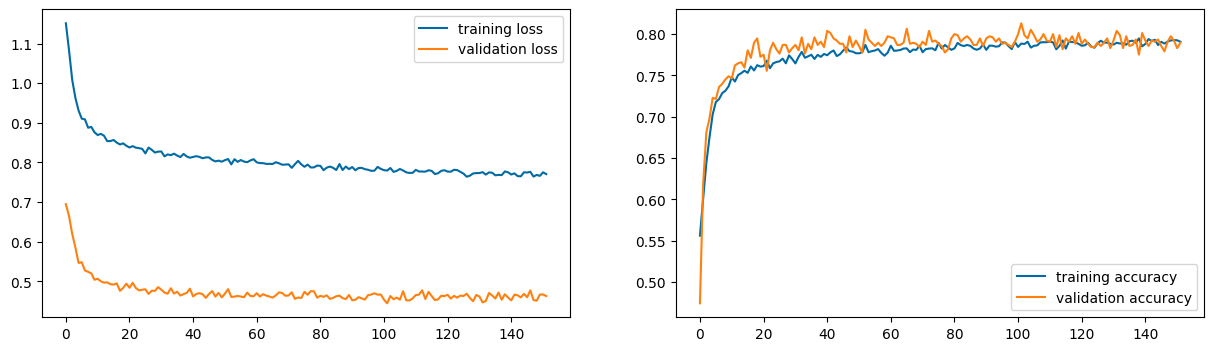

In [ ]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

In [ ]:
# Define model
best_model = EEGNet(nb_classes=2,Chans=64,Samples=156,dropoutRate=0.5,kernLength=64,F1=8,D=2,F2=16,dropoutType='Dropout')

# Load best model weights from h5 file
best_model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.h5")

# Compile best model model
best_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
for i, w in enumerate(best_model.get_weights()):
    print(f"Weight {i}: Shape {w.shape}")

Weight 0: Shape (1, 64, 1, 8)
Weight 1: Shape (8,)
Weight 2: Shape (8,)
Weight 3: Shape (8,)
Weight 4: Shape (8,)
Weight 5: Shape (64, 1, 8, 2)
Weight 6: Shape (16,)
Weight 7: Shape (16,)
Weight 8: Shape (16,)
Weight 9: Shape (16,)
Weight 10: Shape (1, 16, 16, 1)
Weight 11: Shape (1, 1, 16, 16)
Weight 12: Shape (16,)
Weight 13: Shape (16,)
Weight 14: Shape (16,)
Weight 15: Shape (16,)
Weight 16: Shape (64, 2)
Weight 17: Shape (2,)


NF shape: (64, 8)
Coord shape: (64, 2)


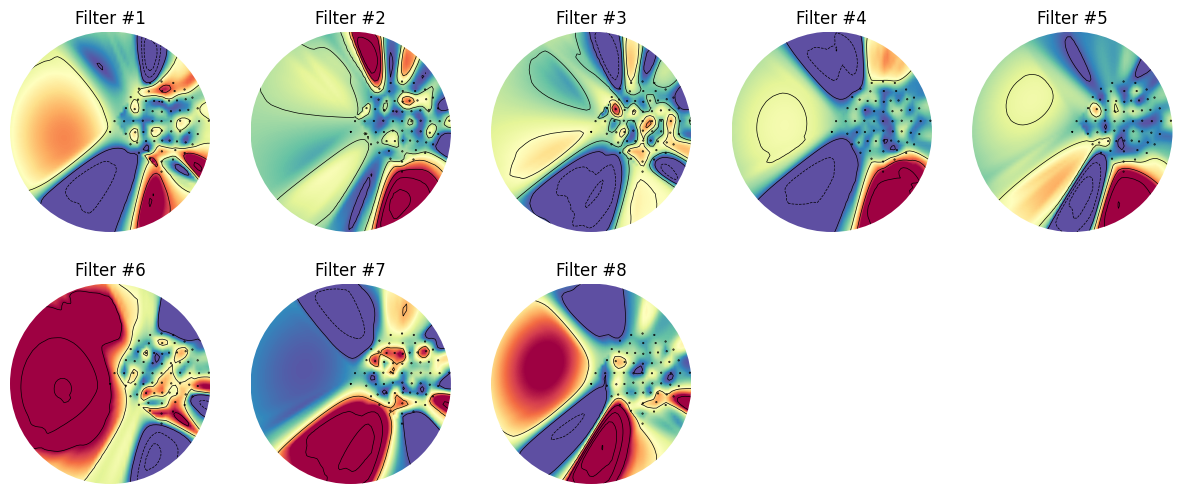

In [ ]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt

if not os.path.exists(CHANNEL_COORD):
    print("Missing file: {}".format(CHANNEL_COORD))
else:
    xycoord = []
    with open(CHANNEL_COORD, "r") as f:
        file_content = f.read()
        for row in file_content.split("\n"):
            if row == '':
                continue
            xycoord.append(row)

coord = np.array([list(map(float, x.split(','))) for x in xycoord], dtype=np.float64)

coord[:, 1] = 681 - coord[:, 1]

nf = np.abs(best_model.get_weights()[0])  # Shape (1, 64, 1, 8)
nf = nf.squeeze()  # (64, 8)

num_filters = nf.shape[1]
print("NF shape:", nf.shape)  # (64, num_filters)
print("Coord shape:", coord.shape)  # (64, 2)

fig = plt.figure(figsize=(15,6))
for i in range(num_filters):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"Filter #{i+1}")
    mne.viz.plot_topomap(nf[:, i], coord, cmap='Spectral_r', axes=ax, show=False)

plt.show()


In [ ]:
test_features = np.transpose(test_features, (0, 2, 1))  #  (None, 64, 156)
test_features = np.expand_dims(test_features, axis=-1)  #  (None, 64, 156, 1)

print("Updated test_features shape:", test_features.shape)  #  (18000, 64, 156, 1)

# one-hot coding
test_labels = to_categorical(test_labels, num_classes=2)
print("Updated test_labels shape:", test_labels.shape)  #  (18000, 2)

Updated test_features shape: (18000, 64, 156, 1)
Updated test_labels shape: (18000, 2)


In [ ]:
print("Updated test_labels shape:", test_labels.shape)  #  (18000, 2)

Updated test_labels shape: (18000, 2)


In [ ]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
print("Predictions shape:", predictions.shape)
predictions = np.round(predictions)

predictions2 = np.argmax(predictions, axis=1)  # (18000,)
print("Updated predictions shape:", predictions2.shape)


score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
test_labels_for_print = np.argmax(test_labels, axis=1)
print("\nPredictions: {}\nSolutions:   {}".format(predictions2[:50].tolist(), test_labels_for_print[:50].tolist()))

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Predictions shape: (18000, 2)
Updated predictions shape: (18000,)
Model performance on test set:	[ Loss: 0.3518	Accuracy: 0.7798 ]

Predictions: [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


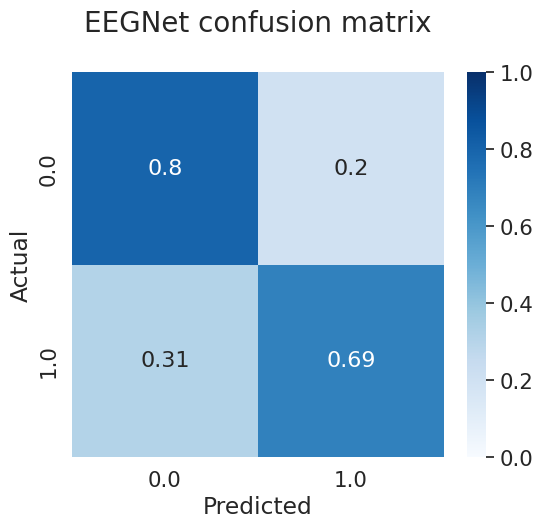

In [ ]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels_for_print , y_pred=predictions2, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("EEGNet confusion matrix\n", fontsize=20)
plt.show()

In [ ]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

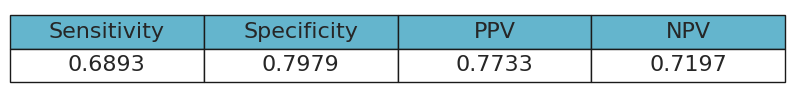

In [ ]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())],
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()